# CS283 Assignement 5: Diffusion Models

In this homework, we are going to implement very simple [Diffusion model](https://arxiv.org/pdf/2006.11239.pdf). This type of models has shown amazing capability of generating photorealistic images with/ without text prompt. They mainly consists of two processes: 
1. Forward Diffusion Process 
2. Reverse Denoising Process

<figure>
<p style="text-align:center;"  align = "center"><img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" alt="Trulli" style="width:100%"  align = "center"></p>
<figcaption align = "center">Forward and Reverse process <a href="https://lilianweng.github.io/posts/2021-07-11-diffusion-models">Ref: Lilian Weng blog</a> </figcaption>
</figure>
 
Before you start — make sure that you understand the corresponding lectures material well.

In this assignment, we are going to do 4 things:

- implement a variance scheduler
- implement a simple forward process
- implement a reverse denoising process
- sampling

What you can and what you cannot do:
- You are free to use whatever code/information you find online, but you **must specify the sources** (otherwise we'll consider that you copied some other student's work)
- You are **not** allowed to put your solution online or share with other students

For questions: reach out through Slack channel

To do this assignment you will need:
- `pytorch3.6+`
- `torch>=1.5`
- `torchvision>=0.4.0`
- `tqdm`, `numpy`, `scipy`, `pillow` and other standard libraries

Since it is very simple diffusion network, you do not need GPU for training.

What you should submit:
- This (solved) notebook named `FIRSTNAME_LASTNAME_CS283_HW5.ipynb`
- You will be deducted 1 point if you do not name your submission properly

------
For questions, please contact Kilichbek Haydarov through Slack.

In [ ]:
#@title
! pip install celluloid
import math
import torch
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
import functools

# For plotting
from IPython.display import HTML
from base64 import b64encode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Utility function for visualization

def show_video(vname):
  mp4 = open(vname,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

def save_animation(vname, interval=30):
  anim = camera.animate(blit=True, interval=interval)
  anim.save(vname)

# Utility function for random noise
def noise_like(shape):
  return torch.randn(size=shape, dtype=torch.float32)

## Data Distribution

Images can be thought of as points sampled from $height \times width$ dimensional space. 

Consider an image of dimension $height \times width$. Then, the total number of pixels are $height \times width$. Each pixel has a value ranging from 0 to 255.
Now, consider a vector space, where we flatten this image and represent the intensity of each pixel along one dimension of the vector space. For example, an image with $height = 2$ and $ width =3$ (2px x 3px image) becomes a single vector of length 6 where each component of this vector will have a value between 0 to 255.

So, in this image vector space, there are small clusters of valid (photorealistic) images sparsely distributed over the space. Rest of the vector space is made up of invalid (not real looking) images.


For the example in this notebook, we consider a **hypothetical** simplified version of the above representation. We consider images made of just 2 pixels, each of which can have values between [-5, 5]. This is to allow visualization of each dimension of the data as it moves through the forward and reverse process (and additionally faster training). 

The same code can be extended to the original image dimensions with just updated data dimensions.

In [ ]:
from sklearn.datasets import make_blobs

# Generate sample data
n_samples = 8000
n_components = 4

X, y_true = make_blobs(
    n_samples=n_samples, 
    centers=n_components, 
    cluster_std=0.2, 
    random_state=0
)
X = X[:, ::-1]
train_data = torch.from_numpy(X.copy()).float()
print(train_data.shape)

torch.Size([8000, 2])


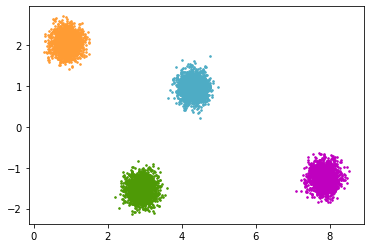

In [ ]:
# let's visualize data distribution
colors = ["#4EACC5", "#FF9C34", "#4E9A06", "m"]

for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(train_data[cluster_data, 0], train_data[cluster_data, 1], c=col, marker=".", s=10)


## Part 1.1 Variance Scheduler (1.0 point)

Once we obtained the data distribution, let's make the first step to build our diffusion model.


The first thing is to add noise to the input images following a fixed variance schedule (also known as beta schedule). The original paper uses a linear schedule, and 1000 timesteps to move forward and back. We use smaller number of timesteps (250) as the data is simpler in our case.
Here, you are required to implement following schedulers:
1. linear  (0.25 point)
2. quadratic (0.25 point)
3. sigmoid (0.25 point)
4. cosine (0.25 point)

In [ ]:
class VarianceScheduler():
    def __init__(self, beta_start=1e-4, beta_end=2e-2):
        self.beta_start = beta_start
        self.beta_end = beta_end

    def get_beta_schedule(self, timesteps, schedule_type='linear'):
        # TODO: implement different types of variance schedulers
        if schedule_type == 'linear':
          # <YOUR CODE HERE>
        if schedule_type == 'quadratic':
          # <YOUR CODE HERE>
        if schedule_type == 'sigmoid':
          # <YOUR CODE HERE>
        if schedule_type == 'cosine':
          # <YOUR CODE HERE>

In [ ]:
timesteps = 250
beta_start = 1e-4
beta_end = 2e-2

beta_scheduler = VarianceScheduler(beta_start, beta_end)

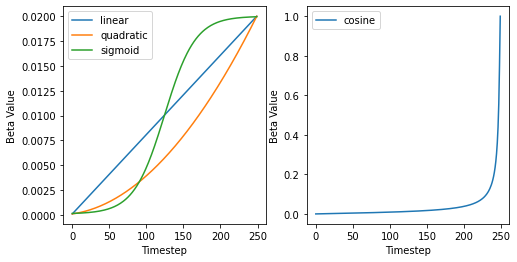

In [ ]:
schedule_types = ['linear', 'quadratic', 'sigmoid', 'cosine']
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for stype in schedule_types:
    betas = beta_scheduler.get_beta_schedule(timesteps, stype)
    i = int(stype == 'cosine')
    axs[i].plot(betas, label=stype)
    axs[i].set_ylabel('Beta Value')
    axs[i].set_xlabel('Timestep')
    axs[i].legend()

### Part 1.2 Beta Derivatives (1.0 points)

Next, let's compute all the derivatives from beta that are used repeatedly in the forward and reverse process of diffusion. Since the variance schedule ($\beta_t$) is fixed, the derivatives of $\beta_t$ are also fixed. We precompute these to save time/compute.


\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
\end{aligned}

We'll see the use cases of these variables in the respective sections below.
You need to precompute  following:
1. $\alpha_t = 1 - \beta_t$
2. $\sqrt{\bar \alpha_t}$, where $\bar \alpha_t = \prod_{i=1}^t \alpha_i$

In [ ]:
class BetaDerivatives():
  def __init__(self, betas, dtype=torch.float32):
    """Take in betas and pre-compute the dependent values to use in forward/ backward pass.
    
    Values are precomputed for all timesteps so that they can be used as and
    when required.
    """
    timesteps, = betas.shape
    self.num_timesteps = int(timesteps)
  
    # calculations required for diffusion q(x_t | x_{t-1}) and others
    # pre-compute alphas, cumulative product of alphas, etc.
    # <YOUR CODE HERE>
    self.betas = None
    self.alphas = None
    self.alphas_cumprod = None
    self.alphas_cumprod_prev = None
    self.sqrt_alphas_cumprod = None
    self.sqrt_one_minus_alphas_cumprod = None

  def _gather(self, a, t):
    """
    Utility function to extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1] for broadcasting.
    """
    return torch.gather(a, 0, t).reshape((-1, 1))

In [ ]:
betas = beta_scheduler.get_beta_schedule(timesteps, 'linear')
gdb = BetaDerivatives(betas)

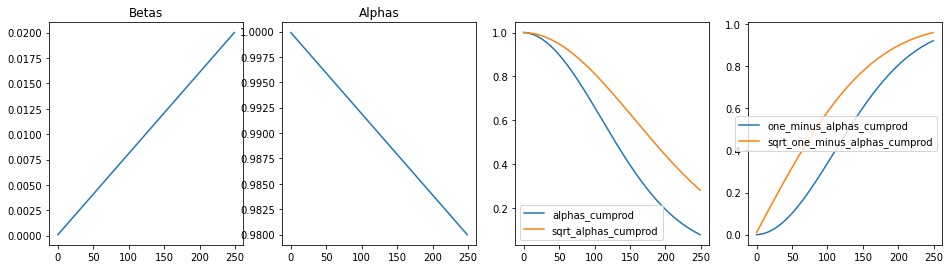

In [ ]:
#@title
# Visualizing betas and other variables
plt.figure(figsize=(16, 9))

plt.subplot(2,4,1)
plt.plot(gdb.betas)
plt.title('Betas')
plt.subplot(2,4,2)
plt.plot(gdb.alphas)
plt.title('Alphas')

plt.subplot(2,4,3)
plt.plot(gdb.alphas_cumprod, label='alphas_cumprod')
plt.plot(gdb.sqrt_alphas_cumprod, label='sqrt_alphas_cumprod')
plt.legend();
plt.subplot(2,4,4)
plt.plot(1-gdb.alphas_cumprod, label='one_minus_alphas_cumprod')
plt.plot(gdb.sqrt_one_minus_alphas_cumprod, label='sqrt_one_minus_alphas_cumprod')
plt.legend();

## Part 2.1 Forward Diffusion Process (1.0 point)

In the forward pass, the diffused input at timestep $t$ can be computed directly using the closed form equation (For derivation of how we arrive at this, refer to the paper).

\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}

Your task is to implement Forward process which samples $x_t$ at any arbitrary time step $t$ due to "nice property" of this process:

\begin{aligned}
x_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
\end{aligned}

In [ ]:
class DiffusionForward(BetaDerivatives):
  """
  Forward pass of the diffusion model.
  """

  def __init__(self, betas):
    super().__init__(betas)

  def q_sample(self, x_start, t, noise=None):
    """
    Forward pass - sample of diffused data at time t.
    """
    if noise is None:
      noise = torch.randn(size=x_start.shape)

    # using precomputed the dependent values (e.g alpha, betas)
    # produce noisy data x_t given time t and initial x_0
    # <YOUR CODE HERE>
    return x_t

diff_forward = DiffusionForward(betas)

### Visualize the forward diffusion of the entire data over time

We start with original data distribution and move it through the forward diffusion process 10 steps at a time. We can see that the original data distribution information is lost till it resembles gaussian after a number of diffusion steps. 

Also, the slow perturbations at the start and large ones towards the end as per the beta schedule are evident from the video.

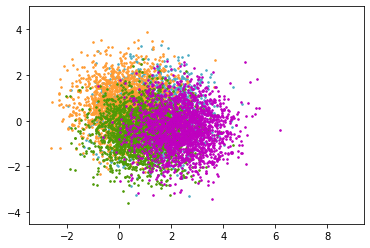

In [ ]:
camera = Camera(plt.figure())

x0 = train_data[:]
for timestep in range(0, timesteps, 10): 
  tstep = torch.from_numpy(np.repeat(timestep, x0.shape[0]))
  shifted = diff_forward.q_sample(x0, tstep)

  for k, col in enumerate(colors):
      cluster_data = y_true == k
      plt.scatter(shifted[cluster_data, 0], shifted[cluster_data, 1], c=col, marker=".", s=10)

  camera.snap()

save_animation('scatter.mp4', 300)

In [ ]:
# let's visualize how the data is being corrupted
show_video('scatter.mp4')

### Visualize the forward pass of single point

We perform the forward diffusion of a single point over time. At every timestep, we generate 500 possible diffused samples of the same input point. We observe the distribution of these points over time. 

These too are closer to the original point at the start and move towards gaussian as the forward process reaches num_timesteps same as the example above.


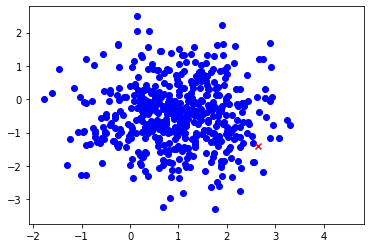

In [ ]:
# let's visualize how the single point in data space is being corrupted
camera = Camera(plt.figure())

x0 = torch.from_numpy(np.tile(X[0], (500, 1)))

for t in range(0, timestep, 10): 
  tstep = torch.from_numpy(np.repeat(t, x0.shape[0]))
  shifted = diff_forward.q_sample(x0, tstep)
  plt.scatter(shifted[:,0], shifted[:,1], c='b')
  plt.scatter(x0[0,0],x0[0,1], marker='x', c='r')
  camera.snap()

save_animation('pointshifting.mp4', 300)

In [ ]:
show_video('pointshifting.mp4')

### Part 2.2 (0.5 point): answer the following question:
1. Why do we need to care so much about the variance scheduler and come up with different types of it? What is the importance of choosing specific variance scheduler? Plot each type of schedulers in the same way as in Part 1.2, and discuss.

> Your answers here

## Part 2.3 Time Embeddings for Diffusion Process (0.5 points)
We create a N-dimensional embedding for the timestep input to the model. We use fixed embeddings similar to positional embeddings in transformers. It can be replaced by trainable embeddings as well.

In [ ]:
class TimeEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # Implement positional embedding for time
        # similar to Transformers
        # <YOUR CODE HERE>
        
        return embeddings

time_emb_size = 128
time_embedder = TimeEmbeddings(time_emb_size)
temb = time_embedder(torch.tensor([2,3]))
print(temb.shape)

torch.Size([2, 128])


## Part 3.1 Define a Denoiser model (1.0 points)

With the data taken care of, let's build a model that can fit the data. We can use a neural networks with few layers since we're just using data with 2 features that we wish to reconstruct. It can be replaced with U-net like architercture with similar loss function in the case of image data.

The model takes in 2 inputs:
* Timestep $t$
* noisified data $x_t$

And predicts 
* The noise $\epsilon_t$ that lead from $x_0$ to $x_t$

In [ ]:
class Denoiser(torch.nn.Module):
    def __init__(self, in_dim, time_emb_dim, out_dim):
        super(Denoiser,self).__init__()
        #<YOUR CODE HERE>

    def forward(self, x, time):

        #<YOUR CODE HERE>   
        return x

In [ ]:
model = Denoiser(2, time_emb_size, 2)
model(torch.randn(1,2), torch.randint(1, 2, size=(1,)))

tensor([[-0.2824,  0.2169]], grad_fn=<AddmmBackward0>)

## Part 3.2 Set up Training procedure (1.0 point)
<figure>
<p style="text-align:center;"  align = "center"><img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png" alt="algorithm" style="width:100%"  align = "center"></p>
<figcaption align = "center">Algorithm for training and sampling<a href="https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/"> Ref: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/</a> </figcaption>
</figure>


We need to set up training process according to Algorithm 1 in the Figure above, specifically steps 2-4.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.inp = torch.stack(transposed_data[0], 0)
        self.t = torch.stack(transposed_data[1], 0)
        self.tgt = torch.stack(transposed_data[2], 0)

    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.t = self.t.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

def collate_wrapper(batch):
    return SimpleCustomBatch(batch)

# <YOUR CODE HERE>
# STEP 1: sample noise from Normal distribution
noise = None
tgts = noise

# STEP 2: sample time steps from Uniform distribution
tstep = None

# STEP 3: corrupt data through forward (defined previously) process using noise
inps = diff_forward.q_sample(train_data, tstep, noise)


dataset = TensorDataset(inps, tstep, tgts)
loader = DataLoader(dataset, batch_size=32, collate_fn=collate_wrapper, shuffle=True)

In [ ]:
from tqdm import tqdm

# define loss function and optimizer
# <YOUR CODE HERE>

EPOCHS = 0
for epoch in tqdm(range(EPOCHS), desc="EPOCH"):
                  
    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    for batch_ndx, sample in enumerate(loader):
        X = sample.inp
        t = sample.t
        y = sample.tgt

        # <YOUR CODE HERE>
        # train your model
        # compute the loss and its gradients
        # adjust learning weights


EPOCH: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


In [ ]:
batch = next(iter(loader))
X, t, y = batch.inp, batch.t, batch.tgt

model.eval()
# inference: predict noise give X, t
# <YOUR CODE HERE>

y = y.detach().cpu().numpy()
ypred = ypred.detach().cpu().numpy()

### Scatter plots of reconstructed values v/s target

When there is a perfect match between the prediction and target, the scatter plot would be a line along y=x (45 degrees in the first quadrant).

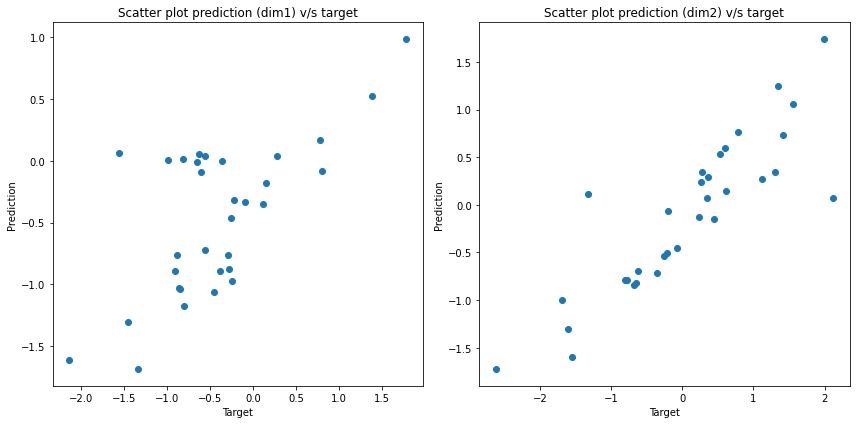

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter( y[:,0], ypred[:,0])
plt.title('Scatter plot prediction (dim1) v/s target')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.subplot(1,2,2)
plt.scatter( y[:,1], ypred[:,1])
plt.title('Scatter plot prediction (dim2) v/s target')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.tight_layout()

## Part 3.3 Reverse process of diffusion (4.0 points)

The model provides a decent estimate of the noise given the data and $x_t$.  Now comes the tricky part: given the data at timestep t $x_t$, and the noise estimate from the model, reconstructing original data distribution.


There are 4 parts in the reverse process: 
1. Pass $x_t$ and $t$ into the model that predicts the noise $ϵ$ (0.5 point)
2. Using the noise estimate $ϵ$ and $x_t$, compute $x_0$ using equation (1.5 point): 

    $\frac{1}{\sqrt{\bar{\alpha}_t}}x_t - (\sqrt{\frac{1}{\bar{\alpha}_t}-1}) \epsilon$ 


3. Compute mean and variance using the equations (1.0 point): 

  $\tilde{\mu}(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1-\bar{\alpha_t}}x_0 + \frac{\sqrt{\bar{\alpha}_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t$ and
variance $\tilde{\beta}_t = \frac{(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\beta_t$ 

4. Sample using this mean and variance (1.0 point):

  $q(x_{t−1}|x_t, x_0)=N(x_{t−1}; \tilde{\mu}(x_t, x_0), \tilde{\beta}_tI)$

In [ ]:
class DiffusionReconstruct(BetaDerivatives):
  
  def __init__(self, betas):
    super().__init__(betas)

    # Precompute necessary components (if any)
    # for alculations required for posterior q(x_{t-1} | x_t, x_0)
    # alphas, betas, reciprocals of alpha, etc.
    # Also, Variance choice corresponds to 2nd choice mentioned in the paper
    # precompute posterior variance according to STEP 3

    # <YOUR CODE HERE>

  def predict_start_from_noise(self, x_t, t, noise):
    """
    Reconstruct x_0 using x_t, t and noise.
    """

    # <YOUR CODE HERE>
    return x_0

  def q_posterior(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior 
    q(x_{t-1} | x_t, x_0)
    """

    # <YOUR CODE HERE>
    return mean, var

  def p_sample(self, model, x_t, t):
    """
    Sample from the model. This does 4 things
    * Predict the noise from the model using x_t and t
    * Create estimate of x_0 using x_t and noise (reconstruction)
    * Estimate of model mean and log_variance of x_{t-1} using x_0, x_t and t
    * Sample data (for x_{t-1}) using the mean and variance values
    """
    # STEP 1: Predict noise from x_t and t
        # <YOUR CODE HERE>

    # STEP 2: Estimate x_0 from x_t and t
        # <YOUR CODE HERE>

    # STEP 3: Estimate mean and log var from x_0 and t
        # <YOUR CODE HERE>

    # STEP 4: Sample data (for x_{t-1}) using the mean and variance values
        # <YOUR CODE HERE>

  def p_sample_loop_trajectory(self, model, shape):
    """
    Generate samples from intermediate steps of the reverse of diffusion
    process.
    """
    times = [self.num_timesteps - 1]
    imgs = [torch.randn(shape)] # start from noise

    while times[-1] >= 0:
        tstep = torch.full((shape[0],), times[-1])
        noisy_imgs = imgs[-1]
        pred = self.p_sample(model=model, x_t=noisy_imgs, t=tstep)
        imgs.append(pred)
        times.append(times[-1] - 1)
        
    return times, imgs

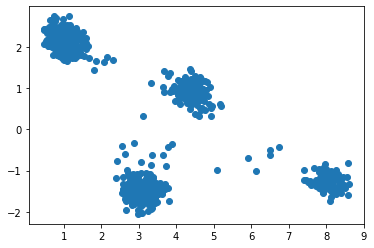

In [ ]:
rec_diff = DiffusionReconstruct(betas)
pred_ts, pred_data = rec_diff.p_sample_loop_trajectory(model, shape=(1000,2))
plt.scatter(pred_data[-1][:,0], pred_data[-1][:,1])

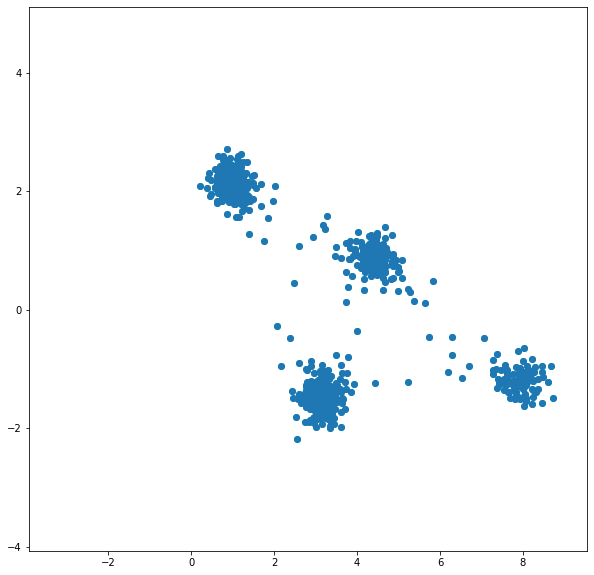

In [ ]:
camera = Camera(plt.figure(figsize=(10,10)))

for timestep in range(0, timesteps): 
  plt.scatter(pred_data[timestep][:,0], pred_data[timestep][:,1])
  camera.snap()

save_animation('outcomes.mp4')

In [ ]:
show_video('outcomes.mp4')